In [23]:
#pip install pmdarima

# Time Series Model with ARIMA 

[10 year US Government Bond Yields (long-term interest rate)](https://datahub.io/core/bond-yields-us-10y#readme)
***

### Steps for ARIMA implementation

- **Load the data**: The first step for model building is of course to load the dataset
- **Preprocessing**: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
- **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
- **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
- **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
- **Determine the p and q values**: Read the values of p and q from the plots in the previous step
- **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
- **Predict values on validation set**: Predict the future values
- **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set
***

# Load the Data

We will include Statsmodels into our workflow which we will use specifically for its powerful TSA models.

In [24]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import kpss

import scipy
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

#matplotlib.rcParams['figure.figsize'] = [8, 3]
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#from matplotlib import rcParams
#from cycler import cycler

#rcParams['figure.figsize'] = 18, 5
#rcParams['axes.spines.top'] = True
#rcParams['axes.spines.right'] = True
#rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
#rcParams['lines.linewidth'] = 2.5

print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('StatsModel:',statsmodels.__version__)
print('Scipy:',scipy.__version__)

Matplotlib: 3.3.2
Pandas: 1.1.3
Numpy: 1.23.0
StatsModel: 0.12.2
Scipy: 1.5.2



# Preprocessing Data

Within reading in our dataframe we can include our datetime and index functions upon our univariate data. 


In [25]:
# Read in data
month = pd.read_excel('/Users/jasonrobinson/Documents/Projects/time_series_analysis/data/U.S. 10-yr-Bond.xls', parse_dates=['Date'], index_col='Date')
print(month.shape)
month.head()

(808, 1)


,Rate
Date,
1953-04-30,2.83
1953-05-31,3.05
1953-06-30,3.11
1953-07-31,2.93
1953-08-31,2.95



### Visualize our data

For the entire range we see an upward and downward non-stationary trend.

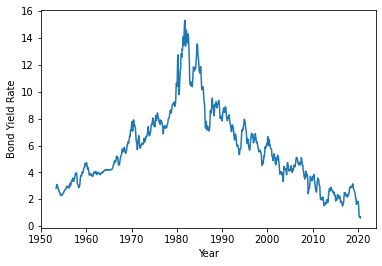

In [26]:
#month.plot(grid=True);
plt.xlabel('Year')
plt.ylabel('Bond Yield Rate')
plt.plot(month)
plt.plot(grid=True)
plt.show();

# Differencing

First order difference with _mean_ and _standard deviation_.

In [27]:
month_log = np.log(month["Rate"])
month_diff = month_log.diff().dropna()

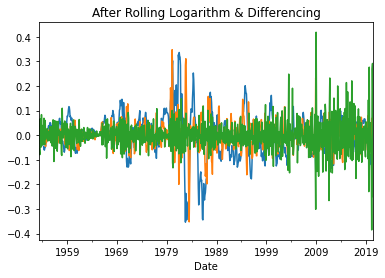

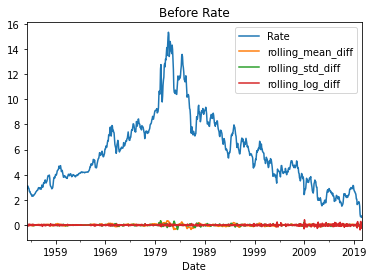

In [28]:
# Differentiate our data to acquire rolling mean
rolling_mean = month['Rate'].rolling(window = 12).mean().dropna()
rolling_std = month['Rate'].rolling(window = 12).std().dropna()

# Current value - past(previous) value
month['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
month['rolling_std_diff'] = rolling_std - rolling_std.shift()
month['rolling_log_diff'] = month_diff - month_diff.shift()

# Differentiated plots
ax1 = plt.subplot()
month['rolling_mean_diff'].plot(title='After Rolling Mean & Differencing');
month['rolling_std_diff'].plot(title='After Rolling Standard Deviation & Differencing');
month['rolling_log_diff'].plot(title='After Rolling Logarithm & Differencing') 

# Before plot
ax2 = plt.subplot()
month.plot(title='Before Rate');

In [30]:
# Remove remaining null values
month_diff = month['rolling_log_diff'].dropna()

In [61]:
#month_diff.to_excel('/Users/jasonrobinson/Documents/Projects/time_series_analysis/data/month_diff.xlsx')


### Seasonal decomposition

Seasonal decomposition

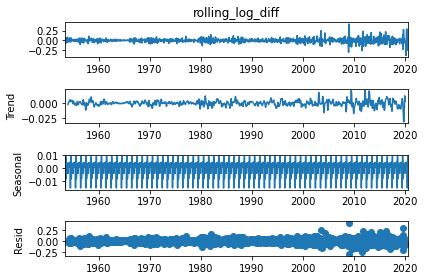

In [83]:
decompose_data = seasonal_decompose(month_diff, model="additive")
decompose_data.plot();

Standard deviation appears to be the least effective at differencing the time series, while log transformation is the right amount of differencing to make the data stationary.

In [34]:
month['1990':'2000'].head()

,Rate,rolling_mean_diff,rolling_std_diff,rolling_log_diff
Date,,,,
1990-01-31,8.21,-0.073333,-0.026482,0.049933
1990-02-28,8.47,-0.058333,-0.050906,-0.014937
1990-03-31,8.59,-0.064167,-0.098399,-0.017109
1990-04-30,8.79,-0.032500,-0.066384,0.008948
1990-05-31,8.76,-0.008333,-0.014875,-0.026435



### Test for Stationarity

Visually we see that our time series is stationary, but to confirm, let us check statistics through the _Augmented Dickey-Fuller Test_ (ADFTest) or the _Kwiatkowski-Phillips-Schmidt-Shin_ (KPSS) _test_, that can tell us if our p-value is greater than 95% to be considered for rejection or failure to reject. 

In [73]:
from pmdarima.arima import ADFTest
# Augmented Dickey-Fuller test

#adf_test = ADFTest(alpha=0.05)
#adf_test.should_diff(month['rolling_log_diff'])

In [35]:

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(month_diff)

(0.01, False)

In [36]:
from statsmodels.tsa.stattools import adfuller


def adf_test(month):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(month['rolling_log_diff'], autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )

      
adf_test(month)

Results of Dickey-Fuller Test:


In [82]:
from statsmodels.tsa.stattools import kpss


def kpss_test(month):
    print("Results of KPSS Test:")
    kpsstest = kpss(month_diff, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    
    
kpss_test(month)

Results of KPSS Test:
Test Statistic             0.160310
p-value                    0.038075
Lags Used                229.000000
Critical Value (10%)       0.119000
Critical Value (5%)        0.146000
Critical Value (2.5%)      0.176000
Critical Value (1%)        0.216000
dtype: float64



###  Make Series Stationary


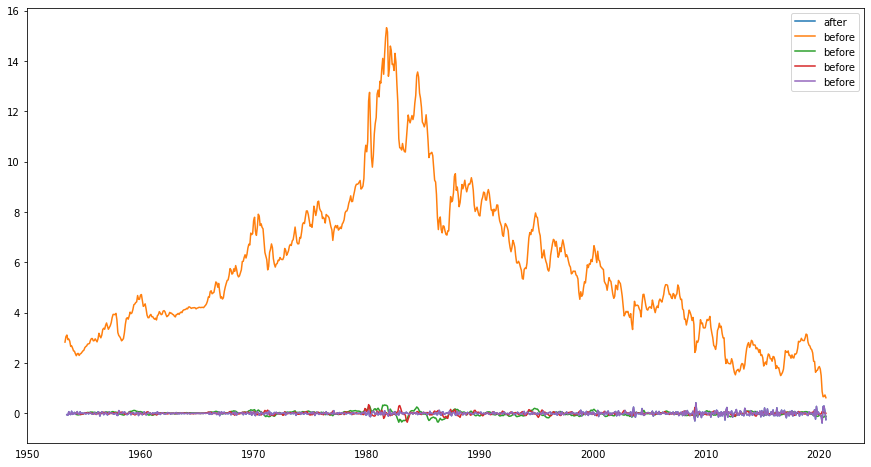

In [40]:
# Before and After confirmation
plt.figure(figsize=(15,8))
plt.plot(month_diff,label="after")
plt.plot(month,label="before")
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.legend()
plt.show()

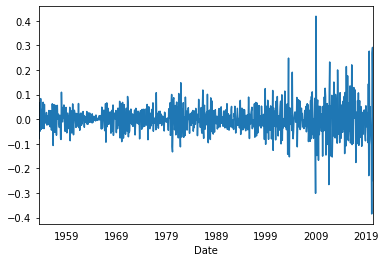

In [41]:
# Closer display
month_diff.plot()
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.show();

# ARIMA Building

After confirming that our data is stationary, we can now build our ARIMA model to predict the bond rate for a period of 3-5 years. To help with determing the parameters for the model we will apply the _Auto Correlation Function_ (ACF) and the _Partial Auto Correlation Function_ (PACF). 


### ACF and PACF

We can use these two functions to allow us to see at which level of lag is most significant towards the current value.


In [42]:
# Autocorrelation and Partial Autocorrelation
acf_month = acf(month_diff)
pacf_month = pacf(month_diff)

In [65]:
np.round(acf_month, 2)

array([ 1.  , -0.25, -0.27,  0.02,  0.01,  0.  , -0.03, -0.  , -0.  ,
        0.02, -0.  ,  0.05, -0.03, -0.05,  0.01,  0.05,  0.01, -0.08,
        0.05, -0.03,  0.07, -0.03, -0.01,  0.03, -0.01, -0.03,  0.04,
       -0.03,  0.  ,  0.02,  0.03, -0.08,  0.02,  0.06, -0.08,  0.07,
       -0.  , -0.08,  0.08, -0.03, -0.04])

In [66]:
np.round(pacf_month, 2)

array([ 1.  , -0.25, -0.36, -0.2 , -0.19, -0.14, -0.16, -0.14, -0.15,
       -0.11, -0.12, -0.02, -0.05, -0.07, -0.07, -0.01,  0.01, -0.07,
        0.  , -0.09,  0.03, -0.05, -0.02,  0.  ,  0.01, -0.04,  0.02,
       -0.05, -0.01, -0.02,  0.04, -0.09, -0.02,  0.02, -0.08,  0.06,
        0.02, -0.04,  0.07,  0.  , -0.02])

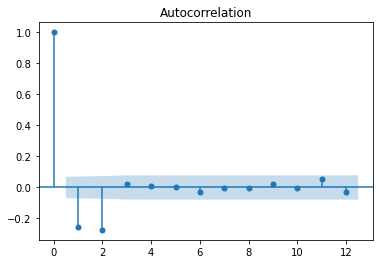

In [64]:
# Visualize our lags and confidence intervals
# 2 lags behind for the autoregressive part
plot_acf(month_diff, lags=12);

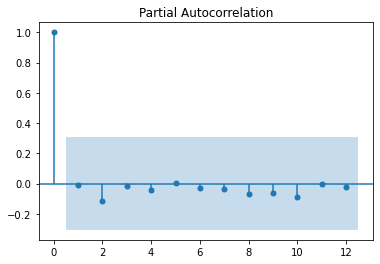

In [44]:
plot_pacf(pacf_month, lags=12);


From the acf and pacf we can determine that in the autocorrelation the first two values are outside of our confidence interval.


## ARIMA

Beginning with ARIMA we will compare other family models for demonstration purposes such as SARIMAX and then Auto-ARIMA.

From our correlation plots the ACF tells us most significant lags in respect to the number of months of the bond yield rate being low or experiencing the greatest change in variance.

In [45]:
# For an arima model we need to split our training and test data
train = month_diff.iloc[:len(month_diff)-12]
test = month_diff.iloc[len(month_diff)-12:]

Use acf and pacf values to determine parameters for the type of arima model we will use for our predictions. According to the lags we will use 0 as our (_AR_), 1 (_I_) for our inegration of differencing order, and 0 (_MA_) for our moving average. Thus we want to builda a (0, 1, 0) ARIMA model.

In [67]:
# Fit our model
from statsmodels.tsa.arima_model import ARIMA

# 0,1,0 ARIMA Model
model = ARIMA(month_diff, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.rolling_log_diff   No. Observations:                  805
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 938.707
Method:                       css-mle   S.D. of innovations              0.075
Date:                Tue, 26 Jul 2022   AIC                          -1869.414
Time:                        19:22:28   BIC                          -1850.651
Sample:                    07-31-1953   HQIC                         -1862.209
                         - 07-31-2020                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     1.599e-05      0.001      0.013      0.989      -0.002       0.002
ar.L1.D.rolling_log_diff    -0.7399      0.031    -23.680      0.000      -0.801      -0.

TypeError: float() argument must be a string or a number, not 'ARIMA'

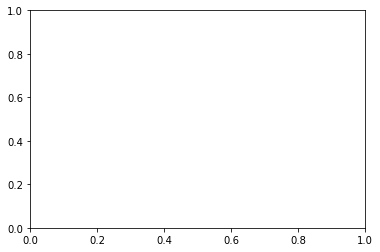

In [81]:
# Plot results
plt.plot(model, label='arima')
plt.plot(month['Rate'][:-2], label='actual')
plt.title('Single-step Forecasting')
plt.grid()
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Section End

In [131]:
# Evaluate parameters
p_values = [0, 1, 2, 3, 9, 12]
d_values = range(0, 3)
q_values = [0, 1, 2, 3]

In [137]:
# Evaluate model using grid search
def evaluate_models(month, p_values, d_values, q_values):
    dataset = month_diff.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [134]:
# Fit our model
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [ ]:
evaluate_models(month_diff, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.092
ARIMA(0, 0, 1) RMSE=0.078
ARIMA(0, 0, 2) RMSE=0.076
ARIMA(0, 0, 3) RMSE=0.076
ARIMA(0, 1, 0) RMSE=0.147
ARIMA(0, 1, 1) RMSE=0.092
ARIMA(0, 1, 2) RMSE=0.078
ARIMA(0, 1, 3) RMSE=0.075
ARIMA(0, 2, 0) RMSE=0.255
ARIMA(0, 2, 1) RMSE=0.147
ARIMA(0, 2, 2) RMSE=0.093
ARIMA(0, 2, 3) RMSE=0.083
ARIMA(1, 0, 0) RMSE=0.089
ARIMA(1, 0, 1) RMSE=0.075
ARIMA(1, 0, 2) RMSE=0.076
ARIMA(1, 0, 3) RMSE=0.075
ARIMA(1, 1, 0) RMSE=0.127
ARIMA(1, 1, 1) RMSE=0.089
ARIMA(1, 1, 2) RMSE=0.093
ARIMA(1, 1, 3) RMSE=0.078
ARIMA(1, 2, 0) RMSE=0.195
ARIMA(1, 2, 1) RMSE=0.127
ARIMA(1, 2, 2) RMSE=0.098
ARIMA(1, 2, 3) RMSE=0.092
ARIMA(2, 0, 0) RMSE=0.084
ARIMA(2, 0, 1) RMSE=0.075
ARIMA(2, 0, 2) RMSE=0.075
ARIMA(2, 0, 3) RMSE=0.076
ARIMA(2, 1, 0) RMSE=0.112
ARIMA(2, 1, 1) RMSE=0.084


In [ ]:
# Prediction

In [ ]:
# Visualize plots


## Auto-ARIMA

In [ ]:
#pd.options.display.max_rows=None
#month['rolling_mean_diff'] = month['rolling_mean_diff'].dropna(inplace=False)
#month['rolling_mean_diff']

In [63]:
month_fit = auto_arima(month_diff,start_p=0, d=1, start_q=0, 
                          max_p=3, max_d=3, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=42,n_fits = 50 )

#print(month_fit.summary().tables[1])
month_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-910.123, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1319.854, Time=0.42 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1112.177, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1411.055, Time=0.88 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-1440.586, Time=2.38 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=12.26 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.49 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=-1243.523, Time=1.82 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=-1670.840, Time=2.18 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-1627.555, Time=1.89 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=10.05 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.57 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=-1782.360, Time=3.52 sec
 ARIMA(3,1,0)(2,1,0)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  806
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood                 898.180
Date:                            Sun, 24 Jul 2022   AIC                          -1782.360
Time:                                    20:53:06   BIC                          -1749.629
Sample:                                         0   HQIC                         -1769.781
                                            - 806                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9210      0.018    -50.499      0.000      -0.957      -0.885
ar.L2         -0.7928      0.022    -35.608      0.000      -0.836      -0.749
ar.L3         -0.3777      0.020    -19.058      0.000      -0.417      -0.339
ar.S.L12      -0.7954      0.029    -27.479      0.000      -0.852      -0.739
ar.S.L24      -0.5308      0.033    -16.022      0.000      -0.596      -0.466
ar.S.L36      -0.2721      0.032     -8.480      0.000      -0.335      -0.209
sigma2         0.0060      0.000     35.393      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                  11.51   Jarque-Bera (JB):               866.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.45   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

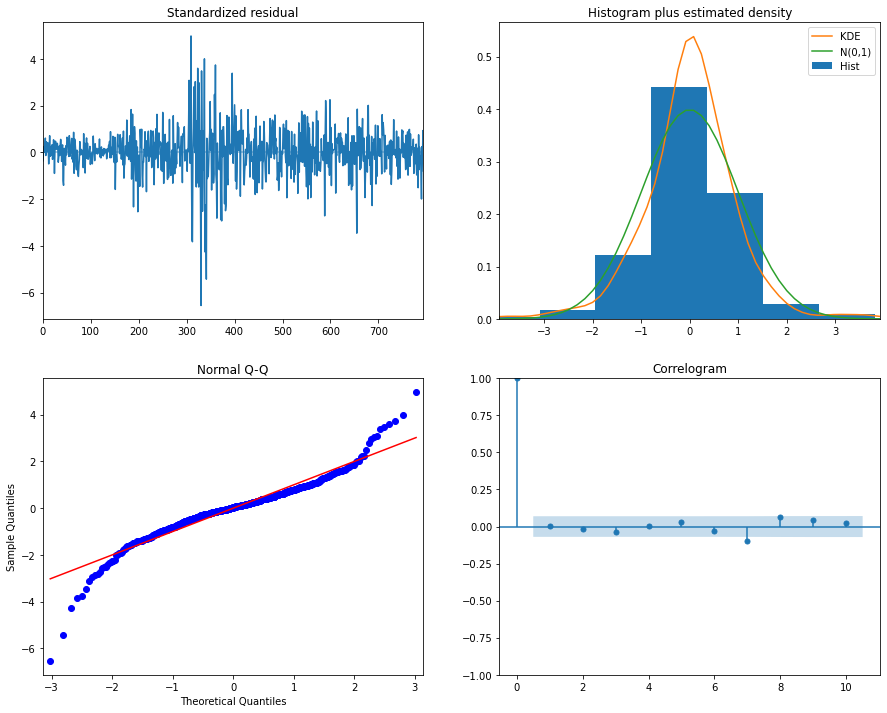

In [197]:
month_fit.plot_diagnostics(figsize=(15, 12))
plt.show();


## SARIMAX

Using the SARIMAX model we will incorporate two orders. The first-order is p,d,q and the other is P,D,Q,m to accountfor seasonality.

In [198]:
month['rolling_mean_diff'].plot(figsize=(15, 6))
plt.show()

KeyError: 'rolling_mean_diff'

In [59]:
train = month['rolling_mean_diff'].iloc[:len(month['rolling_mean_diff'])-12]
test = month['rolling_mean_diff'].iloc[len(month['rolling_mean_diff'])-12:]
test.index, train

(DatetimeIndex(['2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
                '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
                '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31'],
               dtype='datetime64[ns]', name='Date', freq=None),
 Date
 1953-05-31    0.22
 1953-06-30    0.06
 1953-07-31   -0.18
 1953-08-31    0.02
 1953-09-30   -0.08
               ... 
 2019-03-31   -0.11
 2019-04-30   -0.04
 2019-05-31   -0.13
 2019-06-30   -0.33
 2019-07-31   -0.01
 Name: rolling_mean_diff, Length: 795, dtype: float64)

In [68]:
# Split data into train / test sets
train = month['Rate'].iloc[:len(month['Rate'])-12]
test = month['Rate'].iloc[len(month['Rate'])-12:] # set one year(12 months) for testing
  
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train, 
                order = (2, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
  
result = model.fit()
result.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04432D-01    |proj g|=  1.08090D+00

At iterate    5    f=  1.46807D-01    |proj g|=  1.61972D-01

At iterate   10    f=  9.45784D-02    |proj g|=  2.49722D-01

At iterate   15    f=  5.31651D-02    |proj g|=  4.15466D-02

At iterate   20    f=  4.65236D-02    |proj g|=  4.43015D-03

At iterate   25    f=  4.59042D-02    |proj g|=  1.15511D-02

At iterate   30    f=  4.58638D-02    |proj g|=  6.97920D-04

At iterate   35    f=  4.58546D-02    |proj g|=  5.77267D-03

At iterate   40    f=  4.58476D-02    |proj g|=  9.13301D-04

At iterate   45    f=  4.58435D-02    |proj g|=  9.98557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Rate   No. Observations:                  795
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -36.445
Date:                            Sat, 23 Jul 2022   AIC                             86.891
Time:                                    17:57:27   BIC                            119.524
Sample:                                05-31-1953   HQIC                            99.440
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1124      0.069     -1.636      0.102      -0.247       0.022
ar.L2         -0.0594      0.036     -1.658      0.097      -0.130       0.011
ma.L1          0.5122      0.070      7.319      0.000       0.375       0.649
ar.S.L12      -0.0551      0.027     -2.049      0.040      -0.108      -0.002
ar.S.L24      -0.0203      0.036     -0.564      0.573      -0.091       0.050
ma.S.L12      -0.9966      0.167     -5.950      0.000      -1.325      -0.668
sigma2         0.0602      0.010      6.192      0.000       0.041       0.079
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1004.10
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [140]:
pred = result.get_prediction(start='2018-08-31', dynamic=False)
pred_ci = pred.conf_int()

KeyError: 'rolling_mean__diff'

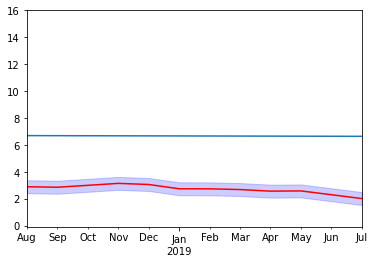

In [150]:
#pred = month['rolling_mean_diff'][750:-1]
pred.predicted_mean.plot(color='red', label='Predicted')
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], 
                 color='blue', alpha=.2)

plt.plot(month['Rate'], label='Rate')
plt.plot(month['rolling_mean__diff'], label='First-order difference', color='orange')
plt.plot(test, label='Actual', alpha=0.7)
plt.title('SARIMA Model')
plt.legend()
plt.show()
;

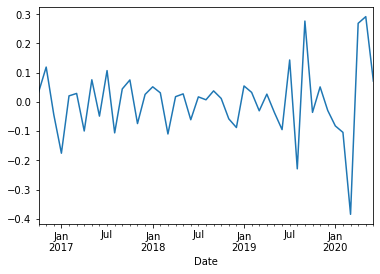

In [129]:
# Rises every 6 months (seasonal)
month['rolling_log_diff'][750:-1].plot();

In [130]:
start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);

AttributeError: 'tuple' object has no attribute 'predict'

In [120]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

rmse(test, predictions)
mean_squared_error(test, predictions)

NameError: name 'predictions' is not defined

In [ ]:
# Train the model on the full dataset
model = model = SARIMAX(month_diff, 
                        order = (2, 1, 0), 
                        seasonal_order =(1, 1, 0, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(month_diff), 
                          end = (len(month_diff)-1) + 3 * 3
                          , 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
month_diff.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True);



### Alternate version


In [ ]:
mod = sm.tsa.statespace.SARIMAX(month['Rate'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

In [ ]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()
predict_ci

Clearly we see that the model is not predicting well according to our predictions. However, an attempt will be made to determine if parameter tuning would extend the results that we desire.